# Mlperf-Client

****User****: 
- *Call Batch Inference*
    1. Run batch workflow based on mlperf inference
- *Call Online Inference*
    1. start mlperf inference loadgen client
    2. send request to online-inference by using modified mlperf inference seldon server(using seldonclient)

In [1]:
import tensorflow as tf
model = tf.saved_model.load("../../mlperf/model/0", tags=None, options=None)

In [2]:
signatures = list(model.signatures.keys())
print(signatures)

['serving_default']


In [3]:
##Tips: the parameter model_name,input,output should be the same as defined inside signature.
infer = model.signatures['serving_default']
print(infer)

<ConcreteFunction pruned(input_image) at 0x2B61AFECCFA0>


In [4]:
# print(infer.inputs)
print(infer.outputs)
# print(infer.variables)

[<tf.Tensor 'predictions/Softmax:0' shape=(None, 1000) dtype=float32>]


In [5]:
import tensorflow as tf
model = tf.saved_model.load("../model/mobilenet/tf/model/0", tags=None, options=None)

In [6]:
signatures = list(model.signatures.keys())
print(signatures)

['serving_default']


In [7]:
##Tips: the parameter model_name,input,output should be the same as defined inside signature.
infer = model.signatures['serving_default']
print(infer)

ConcreteFunction signature_wrapper(*, input_7)
  Args:
    input_7: float32 Tensor, shape=(None, 224, 224, 3)
  Returns:
    {'predictions': <1>}
      <1>: float32 Tensor, shape=(None, 1000)


In [8]:
print(infer.structured_input_signature)

((), {'input_7': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_7')})


In [9]:
# print(infer.inputs)
print(infer.outputs)
# print(infer.variables)

[<tf.Tensor 'Identity:0' shape=(None, 1000) dtype=float32>]


In [10]:
import tensorflow as tf
model = tf.saved_model.load("/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/performanceanalysis/yaml/model/resnet/1538687457", tags=None, options=None)

In [11]:
signatures = list(model.signatures.keys())
print(signatures)

['serving_default', 'predict']


In [17]:
##Tips: the parameter model_name,input,output should be the same as defined inside signature.
infer = model.signatures['predict']
print(infer)

<ConcreteFunction pruned(image_bytes) at 0x2B6237F3C7F0>


In [18]:
print(infer.structured_input_signature)

((), {'image_bytes': TensorSpec(shape=(None,), dtype=tf.string, name='image_bytes')})


In [20]:
print(infer.inputs)
print(infer.outputs)
# print(infer.variables)

[<tf.Tensor 'input_tensor:0' shape=(None,) dtype=string>]
[<tf.Tensor 'ArgMax:0' shape=(None,) dtype=int64>, <tf.Tensor 'softmax_tensor:0' shape=(None, 1001) dtype=float32>]


In [22]:
from __future__ import print_function

import base64
import io
import json

import numpy as np
from PIL import Image
import requests

# The server URL specifies the endpoint of your server running the ResNet
# model with the name "resnet" and using the predict interface.
SERVER_URL = 'http://172.30.0.49:8501/v1/models/resnet:predict'
#SERVER_URL = 'http://localhost:8501/v1/models/resnet:predict'

# The image URL is the location of the image we should send to the server
IMAGE_URL = 'https://tensorflow.org/images/blogs/serving/cat.jpg'

# Current Resnet model in TF Model Garden (as of 7/2021) does not accept JPEG
# as input
#MODEL_ACCEPT_JPG = False
MODEL_ACCEPT_JPG = True

def main():
  # Download the image
  dl_request = requests.get(IMAGE_URL, stream=True)
  dl_request.raise_for_status()

  if MODEL_ACCEPT_JPG:
    print('modelacceptjpg')
    # Compose a JSON Predict request (send JPEG image in base64).
    jpeg_bytes = base64.b64encode(dl_request.content).decode('utf-8')
    predict_request = '{"instances" : [{"b64": "%s"}]}' % jpeg_bytes
  else:
    print('sendtensor')
    # Compose a JOSN Predict request (send the image tensor).
    jpeg_rgb = Image.open(io.BytesIO(dl_request.content))
    # Normalize and batchify the image
    jpeg_rgb = np.expand_dims(np.array(jpeg_rgb) / 255.0, 0).tolist()
    predict_request = json.dumps({'instances': jpeg_rgb})
    #print(predict_request)

  # Send few requests to warm-up the model.
  for _ in range(3):
    response = requests.post(SERVER_URL, data=predict_request)
    response.raise_for_status()

  # Send few actual requests and report average latency.
  total_time = 0
  num_requests = 1
  for _ in range(num_requests):
    response = requests.post(SERVER_URL, data=predict_request)
    response.raise_for_status()
    total_time += response.elapsed.total_seconds()
    print(response)
    prediction = response.json()['predictions'][0]

  print('Prediction class: {}, avg latency: {} ms'.format(
      np.argmax(prediction), (total_time * 1000) / num_requests))


if __name__ == '__main__':
  main()

modelacceptjpg


ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

## Batch-inference Client

for batch-inference client, client similar as we did in dataengineer team, client could call 'run_workflow'.

In [ ]:
sudo cp -r data_imagenet/ /gpfs/bsc_home/xpliu/pv/scanflow-output/batch-inference-single-output/
sudo cp -r data_imagenet/ /gpfs/bsc_home/xpliu/pv/scanflow-output/batch-inference-graph-output/

In [14]:
await deployerClient.run_workflow(app_name='mlperf', 
                                  team_name='dataengineer',
                                  workflow = build_app.workflows[0])

22-Jun-21 10:13:23 -  INFO - [+] output dir /workflow
22-Jun-21 10:13:23 -  INFO - [+] Create batch-inference-single output PV
22-Jun-21 10:13:23 -  INFO - create_pv true
22-Jun-21 10:13:23 -  INFO - [+] Create batch-inference-single output PVC
22-Jun-21 10:13:23 -  INFO - create_pvc true
22-Jun-21 10:13:23 -  INFO - output dir created
22-Jun-21 10:13:23 -  INFO - env for executor {'AWS_ACCESS_KEY_ID': 'admin', 'AWS_SECRET_ACCESS_KEY': 'admin123', 'MLFLOW_S3_ENDPOINT_URL': 'http://minio.minio-system.svc.cluster.local:9000', 'AWS_ENDPOINT_URL': 'http://minio.minio-system.svc.cluster.local:9000', 'SCANFLOW_TRACKER_URI': 'http://scanflow-tracker-service.scanflow-system.svc.cluster.local', 'SCANFLOW_SERVER_URI': 'http://scanflow-server-service.scanflow-system.svc.cluster.local', 'SCANFLOW_TRACKER_LOCAL_URI': 'http://scanflow-tracker.scanflow-mlperf-dataengineer.svc.cluster.local'}
22-Jun-21 10:13:23 -  INFO - [+] Building workflow: [batch-inference-single:predictor-batch].
22-Jun-21 10:13:

OrderedDict([('apiVersion', 'argoproj.io/v1alpha1'), ('kind', 'Workflow'), ('metadata', {'name': 'batch-inference-single'}), ('spec', {'entrypoint': 'batch-inference-single', 'volumes': [OrderedDict([('name', 'outputpath'), ('persistentVolumeClaim', {'claimName': 'batch-inference-single'})]), OrderedDict([('name', 'scanflowpath'), ('persistentVolumeClaim', {'claimName': 'scanflow-scanflow-mlperf-dataengineer'})])], 'templates': [OrderedDict([('name', 'batch-inference-single'), ('dag', {'tasks': [OrderedDict([('name', 'predictor-batch'), ('template', 'predictor-batch'), ('arguments', OrderedDict([('parameters', [{'name': 'para-predictor-batch-0', 'value': '--dataset'}, {'name': 'para-predictor-batch-1', 'value': 'imagenet_tflocal'}, {'name': 'para-predictor-batch-2', 'value': '--dataset-path'}, {'name': 'para-predictor-batch-3', 'value': '/tmp/inference/vision/classification_and_detection/test_imagenet'}, {'name': 'para-predictor-batch-4', 'value': '--scenario'}, {'name': 'para-predicto

True

In [18]:
await deployerClient.run_workflow(app_name='mlperf', 
                                  team_name='dataengineer',
                                  workflow = build_app.workflows[1])

24-Jun-21 19:04:36 -  INFO - [+] output dir /workflow
24-Jun-21 19:04:36 -  INFO - [+] Create batch-inference-graph output PV
24-Jun-21 19:04:36 -  INFO - create_pv true
24-Jun-21 19:04:36 -  INFO - [+] Create batch-inference-graph output PVC
24-Jun-21 19:04:36 -  INFO - create_pvc true
24-Jun-21 19:04:36 -  INFO - output dir created
24-Jun-21 19:04:36 -  INFO - env for executor {'AWS_ACCESS_KEY_ID': 'admin', 'AWS_SECRET_ACCESS_KEY': 'admin123', 'MLFLOW_S3_ENDPOINT_URL': 'http://minio.minio-system.svc.cluster.local:9000', 'AWS_ENDPOINT_URL': 'http://minio.minio-system.svc.cluster.local:9000', 'SCANFLOW_TRACKER_URI': 'http://scanflow-tracker-service.scanflow-system.svc.cluster.local', 'SCANFLOW_SERVER_URI': 'http://scanflow-server-service.scanflow-system.svc.cluster.local', 'SCANFLOW_TRACKER_LOCAL_URI': 'http://scanflow-tracker.scanflow-mlperf-dataengineer.svc.cluster.local'}
24-Jun-21 19:04:36 -  INFO - [+] Building workflow: [batch-inference-graph:download-model].
24-Jun-21 19:04:36 -

OrderedDict([('apiVersion', 'argoproj.io/v1alpha1'), ('kind', 'Workflow'), ('metadata', {'name': 'batch-inference-graph'}), ('spec', {'entrypoint': 'batch-inference-graph', 'volumes': [OrderedDict([('name', 'outputpath'), ('persistentVolumeClaim', {'claimName': 'batch-inference-graph'})]), OrderedDict([('name', 'scanflowpath'), ('persistentVolumeClaim', {'claimName': 'scanflow-scanflow-mlperf-dataengineer'})])], 'templates': [OrderedDict([('name', 'batch-inference-graph'), ('dag', {'tasks': [OrderedDict([('name', 'download-model'), ('template', 'download-model'), ('arguments', OrderedDict([('parameters', [{'name': 'para-download-model-0', 'value': '--app_name'}, {'name': 'para-download-model-1', 'value': 'mlperf'}, {'name': 'para-download-model-2', 'value': '--team_name'}, {'name': 'para-download-model-3', 'value': 'dataengineer'}, {'name': 'para-download-model-4', 'value': '--model_name'}, {'name': 'para-download-model-5', 'value': 'mlperf-resnet'}])]))]), OrderedDict([('name', 'prepr

True

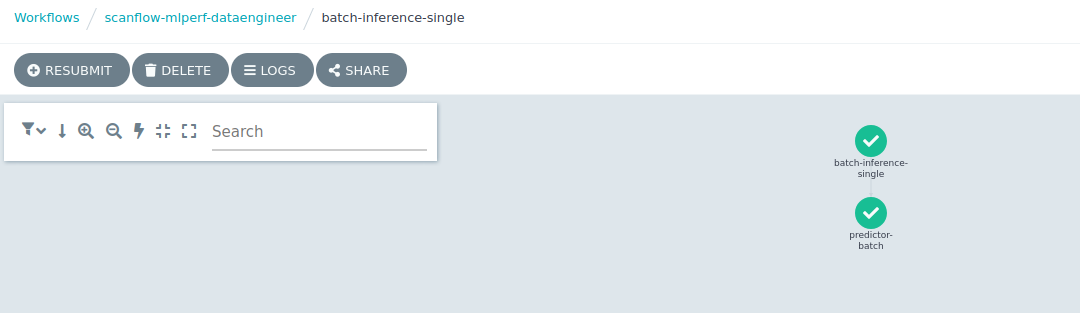

In [19]:
from IPython.display import Image
Image("/gpfs/bsc_home/xpliu/pv/jupyterhubpeini/scanflow/images/mlperf/batch-single.PNG", width=800, height=400)

## Online-inference Client

1. start mlperf inference loadgen client on local or inside a pod
2. send request to online-inference by using modified mlperf inference seldon server(using seldonclient)

#### 1.1 start mlperf client loadgen inside a pod
```bash
kubectl apply -f mlperf.yaml
```

#### 1.2 start mlperf client loadgen locally

In [54]:
!pip list|grep grpc

grpcio                             1.32.0
grpcio-opentracing                 1.1.4
grpcio-reflection                  1.32.0
You should consider upgrading via the '/gpfs/bsc_home/xpliu/anaconda3/bin/python3 -m pip install --upgrade pip' command.


In [55]:
!pip list|grep seldon-core

seldon-core                        1.11.2
You should consider upgrading via the '/gpfs/bsc_home/xpliu/anaconda3/bin/python3 -m pip install --upgrade pip' command.


In [49]:
!cd /gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/ && sh run_scanflow_online.sh

parameter --mlperf_conf ../../mlperf.conf 22 --dataset imagenet_seldon_preprocessed --dataset-path data_imagenet --scenario Offline --model-name resnet50 --server 172.30.0.50:40000 --namespace scanflow-ai-pa --deployment_name online-inference --backend seldon --output outputo --threads 36 --max-batchsize 6
2022-07-31 15:31:19.869535: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/bsc_home/xpliu/mpi/wxparaver-4.8.2-Linux_x86_64/lib64:/gpfs/bsc_home/xpliu/mpi/clusteringsuite-2.6.9-Linux_x86_64/lib64:/gpfs/bsc_home/xpliu/mpi/extrae-3.7.1/build/bin:/gpfs/bsc_home/xpliu/mpi/folding-1.3.2-Linux_x86_64/lib64:/gpfs/bsc_home/xpliu/gcc-5.5.0/build/gcc-5.5.0/lib64:/gpfs/bsc_home/xpliu/openmpi-4.0.3rc3/build/lib:/gpfs/bsc_home/xpliu/spark/rdmasparklib::/gpfs/bsc_home/xpliu/mpi/libpfm-4.10.1/build/lib
2022-07-31 15:31:19.8

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[903], [734], [610], [590], [720], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [495], [495], [404], [610], [590]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[612], [433], [668], [793], [905], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[215], [831], [221], [767], [749], [720]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [892], [125], [969], [610], [700]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[397], [657], [555], [477], [814], [916]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[55], [749], [823], [618], [542], [916]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [631], [401], [548], [416], [794]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[793], [823], [699], [998], [907], [688]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [618], [110], [548], [610], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[805], [998], [979], [78], [548], [720]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[969], [610], [903], [442], [477], [442]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [668], [700], [631], [998], [807]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[998], [884], [740], [397], [891], [920]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[484], [495], [433], [610], [793], [202]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[857], [708], [404], [794], [610], [551]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[442], [644], [610], [532], [793], [532]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[67], [793], [734], [410], [722], [734]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [889], [891], [548], [972], [0]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[903], [404], [793], [548], [610], [892]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[903], [318], [667], [700], [610], [795]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[720], [844], [720], [921], [610], [46]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[454], [700], [610], [814], [558], [442]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[969], [720], [642], [610], [442], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[740], [998], [416], [793], [749], [720]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [106], [749], [910], [548], [590]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[720], [590], [615], [627], [720], [788]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [424], [749], [556], [615], [0]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[636], [884], [610], [903], [610], [590]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [593], [892], [610], [720], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [610], [610], [749], [720], [590]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[564], [903], [610], [998], [610], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[910], [720], [892], [903], [667], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[442], [749], [52], [610], [548], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [749], [583], [445], [587], [54]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[903], [903], [734], [740], [598], [746]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[131], [590], [700], [805], [793], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[61], [720], [905], [982], [610], [700]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[406], [609], [972], [814], [548], [636]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[668], [720], [610], [610], [977], [699]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[402], [496], [657], [875], [793], [998]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [897], [610], [793], [610], [515]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [740], [734], [198], [436], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [982], [555], [720], [610], [395]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[668], [610], [551], [610], [416], [903]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[544], [610], [892], [610], [749], [903]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[793], [740], [720], [740], [610], [57]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[982], [519], [442], [700], [749], [793]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[905], [921], [699], [618], [488], [823]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [590], [548], [982], [793], [106]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[814], [548], [793], [811], [618], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [793], [442], [998], [416], [404]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[449], [793], [477], [319], [610], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [332], [609], [442], [562], [720]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [404], [823], [892], [903], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[450], [793], [610], [548], [720], [734]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response lab

INFO:main:[[618], [749], [793], [619], [216], [106]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[708], [610], [495], [561], [998], [921]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[404], [532], [793], [610], [590], [495]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [95], [691], [548], [610], [982]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[891], [529], [618], [532], [488], [884]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[106], [463], [465], [998], [749], [789]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[793], [749], [720], [980], [590], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[869], [548], [740], [404], [892], [59

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[496], [266], [16], [610], [610], [657]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [610], [435], [83], [749], [106]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[827], [853], [558], [720], [548], [668]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[541], [767], [610], [548], [106], [519]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [548], [529], [548], [610], [793]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [339], [397], [610], [740], [878]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[814], [548], [442], [998], [610], [695]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[740], [749], [404], [749], [969], [793]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[720], [610], [700], [740], [740], [590]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[720], [903], [720], [720], [416], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[667], [668], [488], [998], [548], [998]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[630], [548], [610], [53], [696], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[456], [749], [722], [610], [910], [569]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[857], [982], [749], [477], [862], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:main:[[168], [793], [548], [722], [465], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [891], [740], [532], [410], [495]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[416], [831], [590], [54], [607], [740]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[700], [998], [106], [495], [590], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[720], [548], [610], [548], [477], [814]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[442], [610], [610], [610], [587], [773]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[793], [548], [720], [610], [418], [456]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[587], [477], [495], [445], [609], [40

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [720], [548], [410], [749], [357]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[668], [823], [404], [720], [912], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[442], [740], [548], [749], [918], [61]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [590], [619], [587], [715], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [749], [972], [635], [884], [418]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[353], [442], [720], [823], [548], [720]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[579], [548], [892], [609], [445], [555]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[795], [442], [720], [889], [891], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[905], [172], [488], [659], [814], [635]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[774], [558], [609], [793], [83], [668]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[810], [635], [722], [241], [442], [404]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[555], [713], [76], [700], [442], [473]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [734], [700], [618], [310], [720]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[73], [805], [548], [548], [903], [583]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[814], [916], [55], [749], [823], [618]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[542], [916], [548], [998], [548], [843]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [699], [807], [668], [307], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[823], [535], [590], [410], [548], [905]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [590], [428], [556], [905], [631]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [610], [668], [548], [998], [720]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[903], [795], [610], [850], [610], [446]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[998], [807], [998], [884], [740], [397]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[891], [920], [998], [723], [610], [700]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[590], [749], [793], [903], [700], [793]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[442], [473], [610], [141], [491], [722]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[432], [793], [604], [610], [794], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [609], [805], [814], [613], [650]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [700], [619], [590], [442], [720]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response lab

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[972], [0], [903], [404], [793], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [892], [903], [318], [667], [700]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [795], [969], [720], [60], [814]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[720], [704], [610], [708], [416], [903]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[793], [590], [998], [921], [903], [488]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[404], [610], [720], [998], [715], [880]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[618], [240], [548], [548], [73], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6

INFO:main:[[548], [590], [720], [590], [615], [627]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[720], [788], [610], [424], [749], [556]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[615], [0], [749], [548], [455], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[889], [61], [749], [609], [734], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [899], [610], [724], [536], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[598], [749], [700], [892], [793], [67]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [442], [495], [783], [905], [404]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [410], [793], [749], [903], [715]]

INFO:main:[[667], [749], [442], [749], [52], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [548], [610], [749], [583], [445]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[587], [54], [642], [884], [482], [892]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[722], [795], [442], [590], [610], [700]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [610], [903], [548], [793], [668]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [793], [884], [186], [734], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[645], [548], [590], [610], [640], [590]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[83], [610], [884], [55], [740], [91]]


INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [636], [668], [720], [610], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[977], [699], [402], [496], [657], [875]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[793], [998], [610], [897], [610], [793]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [515], [972], [484], [889], [473]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[678], [903], [734], [734], [587], [823]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[645], [590], [404], [548], [610], [849]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [451], [627], [555], [857], [464]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response lab

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [903], [793], [740], [720], [740]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [57], [982], [519], [442], [700]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [793], [905], [921], [699], [618]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[488], [823], [635], [793], [610], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[972], [43], [442], [338], [903], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[793], [793], [106], [473], [416], [746]]
INFO:main:[[610], [610], [878], [610], [974], [619]]
INFO:main:Call seldon predict
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[416], [404], [449], [793], [477], [319]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [548], [610], [332], [609], [442]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[562], [720], [610], [404], [823], [892]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[903], [749], [450], [793], [610], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[720], [734], [610], [998], [548], [565]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[442], [583], [793], [51], [610], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [644], [587], [488], [610], [892]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [982], [891], [529], [618], [532]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[488], [884], [106], [463], [465], [998]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [789], [793], [749], [720], [980]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[590], [749], [869], [548], [740], [404]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[892], [590], [795], [495], [477], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[477], [720], [720], [404], [610], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[793], [442], [416], [519], [548], [806]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response lab

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [668], [541], [767], [610], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[106], [519], [610], [548], [529], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [793], [610], [339], [397], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [695], [793], [897], [610], [635]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[740], [878], [814], [548], [442], [998]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[448], [516], [793], [442], [590], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[903], [734], [720], [722], [849], [793]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response lab

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[416], [749], [667], [668], [488], [998]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [998], [630], [548], [610], [53]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[696], [749], [456], [749], [722], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[910], [569], [857], [982], [749], [477]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[862], [548], [793], [734], [416], [642]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[49], [590], [442], [720], [590], [720]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[867], [720], [442], [615], [404], [495]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[477], [814], [442], [610], [610], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[587], [773], [793], [548], [720], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[418], [456], [587], [477], [495], [445]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[609], [401], [610], [740], [326], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[903], [734], [610], [590], [720], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [495], [495], [404], [610], [590]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[612], [433], [668], [793], [905], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response lab

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[884], [418], [353], [442], [720], [823]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [720], [579], [548], [892], [609]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[445], [555], [740], [740], [749], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [488], [91], [477], [695], [901]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [631], [401], [548], [416], [794]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[793], [823], [699], [998], [907], [688]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [618], [110], [548], [610], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[442], [473], [610], [734], [700], [618]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[903], [583], [657], [228], [610], [496]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[310], [720], [73], [805], [548], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[720], [793], [787], [749], [598], [740]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[484], [495], [433], [610], [793], [202]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[857], [708], [404], [794], [610], [551]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[442], [644], [610], [532], [793], [532]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [905], [749], [590], [428], [556]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[905], [631], [749], [610], [668], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[998], [720], [903], [795], [610], [850]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [446], [720], [382], [410], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[720], [844], [720], [921], [610], [46]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[454], [700], [610], [814], [558], [442]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[969], [720], [642], [610], [442], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[794], [610], [749], [609], [805], [814]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[613], [650], [610], [700], [619], [590]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[442], [720], [749], [972], [700], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[636], [884], [610], [903], [610], [590]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [593], [892], [610], [720], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [610], [610], [749], [720], [590]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[564], [903], [610], [998], [610], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response lab

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[903], [488], [404], [610], [720], [998]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[715], [880], [618], [240], [548], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[73], [749], [740], [590], [793], [598]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [610], [767], [60], [700], [793]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[903], [903], [734], [740], [598], [746]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[131], [590], [700], [805], [793], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[61], [720], [905], [982], [610], [700]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[536], [610], [598], [749], [700], [892]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[793], [67], [610], [442], [495], [783]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[905], [404], [610], [410], [793], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[903], [715], [720], [610], [610], [657]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [740], [734], [198], [436], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [982], [555], [720], [610], [395]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[668], [610], [551], [610], [416], [903]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[640], [590], [548], [793], [884], [186]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[734], [610], [83], [610], [884], [55]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[740], [91], [700], [615], [442], [806]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[408], [416], [610], [720], [711], [878]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [590], [548], [982], [793], [106]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[814], [548], [793], [811], [618], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [793], [442], [998], [416], [404]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 

INFO:main:[[610], [849], [749], [451], [627], [555]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[857], [464], [590], [548], [734], [461]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [897], [740], [974], [488], [700]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[982], [635], [720], [613], [749], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[618], [749], [793], [619], [216], [106]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[708], [610], [495], [561], [998], [921]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[404], [532], [793], [610], [590], [495]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [95], [691], [548], [610], [98

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [759], [456], [442], [610], [659]]
INFO:main:[[974], [619], [610], [814], [749], [610]]
INFO:main:Call seldon predict
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[590], [610], [610], [891], [289], [410]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[417], [720], [610], [442], [668], [843]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[496], [266], [16], [610], [610], [657]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [610], [435], [83], [749], [106]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[827], [853], [558], [720], [548], [668]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[541], [767], [610], [548], [106], [519

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [700], [610], [749], [610], [972]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[418], [548], [749], [458], [749], [720]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [644], [793], [555], [416], [618]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[740], [749], [404], [749], [969], [793]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[720], [610], [700], [740], [740], [590]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[720], [903], [720], [720], [416], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[667], [668], [488], [998], [548], [998]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response lab

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[720], [793], [749], [800], [619], [893]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[168], [793], [548], [722], [465], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [891], [740], [532], [410], [495]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[416], [831], [590], [54], [607], [740]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[700], [998], [106], [495], [590], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[720], [548], [610], [548], [477], [814]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[442], [610], [610], [610], [587], [773]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [247], [610], [356], [849], [424]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [720], [548], [410], [749], [357]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[668], [823], [404], [720], [912], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[442], [740], [548], [749], [918], [61]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [590], [619], [587], [715], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [749], [972], [635], [884], [418]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[353], [442], [720], [823], [548], [720]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[609], [548], [442], [548], [903], [87]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[795], [442], [720], [889], [891], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[905], [172], [488], [659], [814], [635]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[774], [558], [609], [793], [83], [668]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[810], [635], [722], [241], [442], [404]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[555], [713], [76], [700], [442], [473]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [734], [700], [618], [310], [720]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [720], [548], [892], [125], [969]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [700], [397], [657], [555], [477]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[814], [916], [55], [749], [823], [618]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[542], [916], [548], [998], [548], [843]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [699], [807], [668], [307], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[823], [535], [590], [410], [548], [905]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [590], [428], [556], [905], [631]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[477], [442], [548], [668], [700], [631]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[998], [807], [998], [884], [740], [397]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[891], [920], [998], [723], [610], [700]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[590], [749], [793], [903], [700], [793]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[442], [473], [610], [141], [491], [722]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[432], [793], [604], [610], [794], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [609], [805], [814], [613], [650]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response lab

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[972], [0], [903], [404], [793], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [892], [903], [318], [667], [700]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [795], [969], [720], [60], [814]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[720], [704], [610], [708], [416], [903]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[793], [590], [998], [921], [903], [488]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[404], [610], [720], [998], [715], [880]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[618], [240], [548], [548], [73], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[720], [788], [610], [424], [749], [556]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[615], [0], [749], [548], [455], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[889], [61], [749], [609], [734], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [899], [610], [724], [536], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[598], [749], [700], [892], [793], [67]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [442], [495], [783], [905], [404]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [410], [793], [749], [903], [715]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6

INFO:main:[[548], [548], [610], [749], [583], [445]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[587], [54], [642], [884], [482], [892]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[722], [795], [442], [590], [610], [700]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [610], [903], [548], [793], [668]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[645], [548], [590], [610], [640], [590]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [793], [884], [186], [734], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[83], [610], [884], [55], [740], [91]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [720], [711], [878], [749], [590]]

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[793], [998], [610], [897], [610], [793]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [515], [972], [484], [889], [473]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[678], [903], [734], [734], [587], [823]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[645], [590], [404], [548], [610], [849]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [451], [627], [555], [857], [464]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[590], [548], [734], [461], [548], [897]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[740], [974], [488], [700], [982], [635]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response lab

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[488], [823], [635], [793], [610], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[972], [43], [442], [338], [903], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[793], [793], [106], [473], [416], [746]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [610], [878], [610], [974], [619]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [814], [749], [610], [548], [759]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[456], [442], [610], [659], [590], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [891], [289], [410], [417], [720]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[903], [749], [450], [793], [610], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[720], [734], [610], [998], [548], [565]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[442], [583], [793], [51], [610], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [644], [587], [488], [610], [892]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[72], [450], [451], [434], [548], [700]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [749], [610], [972], [418], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [458], [749], [720], [610], [644]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [789], [793], [749], [720], [980]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[590], [749], [869], [548], [740], [404]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[892], [590], [795], [495], [477], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[477], [720], [720], [404], [610], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[793], [442], [416], [519], [548], [806]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[657], [749], [825], [910], [720], [793]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [722], [465], [610], [610], [891]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response lab

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [793], [610], [339], [397], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [695], [793], [897], [610], [635]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[740], [878], [814], [548], [442], [998]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[448], [516], [793], [442], [590], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[903], [734], [720], [722], [849], [793]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [610], [793], [610], [610], [247]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [356], [849], [424], [548], [720]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response lab

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[696], [749], [456], [749], [722], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[910], [569], [857], [982], [749], [477]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[862], [548], [793], [734], [416], [642]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[49], [590], [442], [720], [590], [720]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[867], [720], [442], [615], [404], [495]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [749], [548], [538], [605], [657]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [668], [610], [548], [609], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[609], [401], [610], [740], [326], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[903], [734], [610], [590], [720], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [495], [495], [404], [610], [590]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[612], [433], [668], [793], [905], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[215], [831], [221], [767], [749], [720]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [892], [125], [969], [610], [700]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[397], [657], [555], [477], [814], [916]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response lab

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [488], [91], [477], [695], [901]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [631], [401], [548], [416], [794]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[793], [823], [699], [998], [907], [688]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [618], [110], [548], [610], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[805], [998], [979], [78], [548], [720]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[969], [610], [903], [442], [477], [442]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [668], [700], [631], [998], [807]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[903], [583], [657], [228], [610], [496]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[720], [793], [787], [749], [598], [740]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[484], [495], [433], [610], [793], [202]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[857], [708], [404], [794], [610], [551]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[442], [644], [610], [532], [793], [532]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[67], [793], [734], [410], [722], [734]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [889], [891], [548], [972], [0]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[998], [720], [903], [795], [610], [850]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [446], [720], [382], [410], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[720], [844], [720], [921], [610], [46]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[454], [700], [610], [814], [558], [442]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[969], [720], [642], [610], [442], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[740], [998], [416], [793], [749], [720]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [106], [749], [910], [548], [590]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[613], [650], [610], [700], [619], [590]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[442], [720], [749], [972], [700], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[636], [884], [610], [903], [610], [590]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [593], [892], [610], [720], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [610], [610], [749], [720], [590]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[564], [903], [610], [998], [610], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[910], [720], [892], [903], [667], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response lab

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[715], [880], [618], [240], [548], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[73], [749], [740], [590], [793], [598]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [610], [767], [60], [700], [793]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[903], [903], [734], [740], [598], [746]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[131], [590], [700], [805], [793], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[61], [720], [905], [982], [610], [700]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[406], [609], [972], [814], [548], [636]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[793], [67], [610], [442], [495], [783]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[905], [404], [610], [410], [793], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[903], [715], [720], [610], [610], [657]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [740], [734], [198], [436], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [982], [555], [720], [610], [395]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[668], [610], [551], [610], [416], [903]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[544], [610], [892], [610], [749], [903]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[734], [610], [83], [610], [884], [55]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[740], [91], [700], [615], [442], [806]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[408], [416], [610], [720], [711], [878]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [590], [548], [982], [793], [106]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[814], [548], [793], [811], [618], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [793], [442], [998], [416], [404]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[449], [793], [477], [319], [610], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 

INFO:BackendSeldon:PEINI: number of response label 6
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [897], [740], [974], [488], [700]]
INFO:main:[[857], [464], [590], [548], [734], [461]]
INFO:main:Call seldon predict
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[982], [635], [720], [613], [749], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[708], [610], [495], [561], [998], [921]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[618], [749], [793], [619], [216], [106]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[404], [532], [793], [610], [590], [495]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [95], [691], [548], [610], [982]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[974], [619], [610], [814], [749], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [759], [456], [442], [610], [659]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[590], [610], [610], [891], [289], [410]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[417], [720], [610], [442], [668], [843]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[496], [266], [16], [610], [610], [657]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [610], [435], [83], [749], [106]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[827], [853], [558], [720], [548], [668]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [700], [610], [749], [610], [972]]
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:Call seldon predict
INFO:main:[[418], [548], [749], [458], [749], [720]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [644], [793], [555], [416], [618]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[740], [749], [404], [749], [969], [793]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[720], [610], [700], [740], [740], [590]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[720], [903], [720], [720], [416], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[667], [668], [488], [998], [548], [998]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response lab

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [806], [657], [749], [825], [910]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[720], [793], [749], [800], [619], [893]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[168], [793], [548], [722], [465], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [891], [740], [532], [410], [495]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[416], [831], [590], [54], [607], [740]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[700], [998], [106], [495], [590], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[720], [548], [610], [548], [477], [814]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[849], [793], [548], [610], [793], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [247], [610], [356], [849], [424]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [720], [548], [410], [749], [357]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[668], [823], [404], [720], [912], [749]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [590], [619], [587], [715], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[442], [740], [548], [749], [918], [61]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [749], [972], [635], [884], [418]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[404], [495], [610], [749], [548], [538]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[605], [657], [610], [668], [610], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[609], [548], [442], [548], [903], [87]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[795], [442], [720], [889], [891], [610]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[905], [172], [488], [659], [814], [635]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[774], [558], [609], [793], [83], [668]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[810], [635], [722], [241], [442], [404]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[905], [548], [215], [831], [221], [767]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [720], [548], [892], [125], [969]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [700], [397], [657], [555], [477]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[814], [916], [55], [749], [823], [618]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[542], [916], [548], [998], [548], [843]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[749], [699], [807], [668], [307], [548]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[823], [535], [590], [410], [548], [905]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[610], [610], [805], [998], [979], [78]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[548], [720], [969], [610], [903], [442]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[477], [442], [548], [668], [700], [631]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[998], [807], [998], [884], [740], [397]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[891], [920], [998], [723], [610], [700]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[590], [749], [793], [903], [700], [793]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[442], [473], [610], [141], [491], [722]]
INFO:main:Call seldon predict
INFO:BackendSeldon:PEINI: number of response labe

INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[793], [590], [998], [921], [903], [488]]
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[404], [610], [720], [998], [715], [880]]
INFO:BackendSeldon:PEINI: number of response label 6
INFO:main:[[618], [240], [548], [548], [73], [749]]
TestScenario.Offline qps=193.31, mean=63.7599, time=127.133, queries=24576, tiles=50.0:63.8735,80.0:101.8014,90.0:114.4719,95.0:120.7971,99.0:125.8437,99.9:126.9745
